# Fraud Detection in Credit Card Transactions

## Random Forest

## Versions

In [24]:
import sys
import numpy
import pandas
import matplotlib
import seaborn
import sklearn
import imblearn
import xgboost

print(f"Python version: {sys.version}")
print(f"Numpy version: {numpy.__version__}")
print(f"Pandas version: {pandas.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")
print(f"Seaborn version: {seaborn.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"Imbalanced-learn version: {imblearn.__version__}")
print(f"XGBoost version: {xgboost.__version__}")

Python version: 3.10.16 | packaged by conda-forge | (main, Dec  5 2024, 14:12:04) [Clang 18.1.8 ]
Numpy version: 2.1.0
Pandas version: 2.2.2
Matplotlib version: 3.9.2
Seaborn version: 0.13.2
Scikit-learn version: 1.5.1
Imbalanced-learn version: 0.13.0
XGBoost version: 2.1.4


## Importing Data

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, average_precision_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN, SMOTE
from xgboost import XGBClassifier

In [26]:
df1 = pd.read_csv('creditcard_part1.csv')
df2 = pd.read_csv('creditcard_part2.csv')

# merge dataframes
ccdata = pd.concat([df1, df2], ignore_index=True)

## Modeling

In [27]:
# k-fold cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)

# function to plot confusion matrix
def plot_confusion_matrix(cm, ax=None, title='Confusion Matrix'):
    if ax is None:
        plt.figure(figsize=(3,3)) # new figure if no axis passed
        ax = plt.gca() # get the current axis

    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['Normal', 'Fraudulent'],
        yticklabels=['Normal', 'Fraudulent'],
        ax=ax
    )
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

# function for validation output
def model_val_eval(model_name, y_val, y_val_pred, y_val_proba):
    auc = roc_auc_score(y_val, y_val_proba)
    report = classification_report(y_val, y_val_pred)
    cm = confusion_matrix(y_val, y_val_pred)
    print('ROC AUC:', auc)
    print('Classification Report:\n', report)
    plot_confusion_matrix(cm, title=f"{model_name} Confusion Matrix")

### Split (60/20/20)

In [28]:
X = ccdata.drop('Class', axis=1) # features
y = ccdata['Class'] # target variable

# 60% training, 20% validation, 20% testing
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=69, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=69, stratify=y_trainval)

#### Checking class imbalance

In [29]:
print(f"Normal Transactions in training set (Class = 0):\t{y_train.value_counts()[0]}\t({y_train.value_counts()[0] / len(y_train)*100:.2f}%)")
print(f"Fraudulent Transactions in training set (Class = 1):\t{y_train.value_counts()[1]}\t({y_train.value_counts()[1] / len(y_train)*100:.2f}%)")

Normal Transactions in training set (Class = 0):	170588	(99.83%)
Fraudulent Transactions in training set (Class = 1):	295	(0.17%)


### Decision Tree

In [30]:
# model initialization
dtc = DecisionTreeClassifier(random_state=69, max_depth=15)

# model training
dtc.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=15, random_state=69)

ROC AUC: 0.8054300101413339
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.80      0.73      0.76        99

    accuracy                           1.00     56962
   macro avg       0.90      0.86      0.88     56962
weighted avg       1.00      1.00      1.00     56962



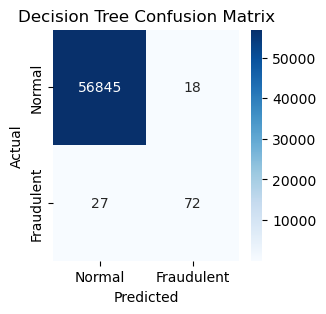

In [31]:
# prediction on validation set
y_val_pred_dtc = dtc.predict(X_val)
y_val_proba_dtc = dtc.predict_proba(X_val)[:, 1]

# model evaluation on validation set
model_val_eval('Decision Tree', y_val, y_val_pred_dtc, y_val_proba_dtc)

A higher precision (80%) and recall (73%) for fraudulent cases would be desirable.

### Random Forest

#### Imbalanced

In [32]:
# model initialization
rfc = RandomForestClassifier(random_state=69)

# hyperparameters to search
param_search = {'n_estimators': [50, 100], # number of trees
              'max_depth': [5, 10, 15], # maximum depth of the tree
#             'max_features': ['auto', 'sqrt', 'log2'] # number of features at each split
}

# searching best hyperparameters
rfc_search = GridSearchCV(
    rfc,
    param_search,
    cv=skf,
    scoring='roc_auc', # use 'roc_auc' or 'average_precision' for imbalanced datasets
    n_jobs=-2 # n_iter=10 is default
) 

# model training
rfc_search.fit(X_train, y_train)

print(f"Best Parameters:\t{rfc_search.best_params_}")

Best Parameters:	{'max_depth': 10, 'n_estimators': 100}


ROC AUC: 0.9804140271931279
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.91      0.73      0.81        99

    accuracy                           1.00     56962
   macro avg       0.96      0.86      0.90     56962
weighted avg       1.00      1.00      1.00     56962



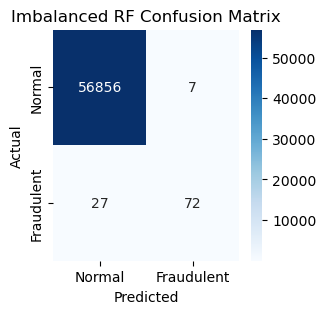

In [33]:
# prediction on validation set
y_val_pred_rfc = rfc_search.predict(X_val)
y_val_proba_rfc = rfc_search.predict_proba(X_val)[:, 1]

# model evaluation on validation set
model_val_eval('Imbalanced RF', y_val, y_val_pred_rfc, y_val_proba_rfc)

While the precision is higher than expected (91%), the random forest does not improve the recall (73%). This is not ideal.

#### Undersampling

Normal Transactions in training set (Class = 0):	295	(50.00%)
Fraudulent Transactions in training set (Class = 1):	295	(50.00%)


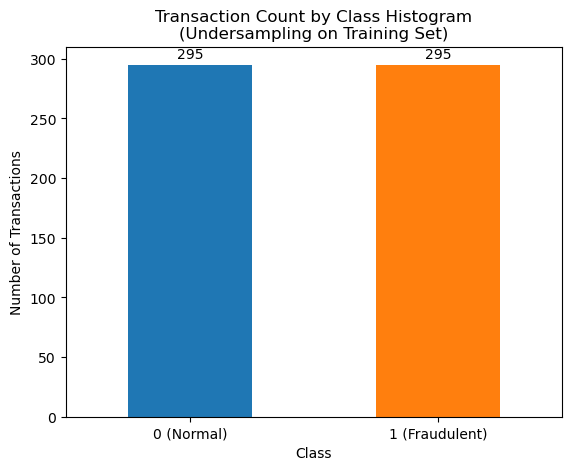

In [34]:
# undersampling method
rus = RandomUnderSampler(random_state=69)

# resampling
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

print(f"Normal Transactions in training set (Class = 0):\t{y_train_under.value_counts()[0]}\t({y_train_under.value_counts()[0] / len(y_train_under)*100:.2f}%)")
print(f"Fraudulent Transactions in training set (Class = 1):\t{y_train_under.value_counts()[1]}\t({y_train_under.value_counts()[1] / len(y_train_under)*100:.2f}%)")

class_vals_under = pd.Series(y_train_under).value_counts().sort_index()
ax = class_vals_under.plot(kind='bar', color=['tab:blue', 'tab:orange'])

plt.title('Transaction Count by Class Histogram\n(Undersampling on Training Set)')
ax.set_xticklabels(['0 (Normal)', '1 (Fraudulent)'], rotation=0)
ax.set_ylabel('Number of Transactions')

for i, v in enumerate(class_vals_under):
    ax.text(i, v + max(v * 0.01, 5), str(v), ha='center');

In [35]:
# model initialization
rfc = RandomForestClassifier(random_state=69)

# hyperparameters to search
param_grid = {'n_estimators': [50, 100] # number of trees
              ,'max_depth': [5, 10, 15] # maximum depth of the tree
#              ,'max_features': ['auto', 'sqrt', 'log2'] # number of features at each split
             }

# searching best hyperparameters
rfc_search_under = GridSearchCV(
    rfc,
    param_grid,
    cv=skf,
    scoring='roc_auc', # use 'roc_auc' or 'average_precision'
    n_jobs=-2 # n_iter=10 is default
)

# model training
rfc_search_under.fit(X_train_under, y_train_under)

print(f"Best Parameters:\t{rfc_search_under.best_params_}")

Best Parameters:	{'max_depth': 15, 'n_estimators': 100}


ROC AUC: 0.9821396882139368
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99     56863
           1       0.06      0.93      0.11        99

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962



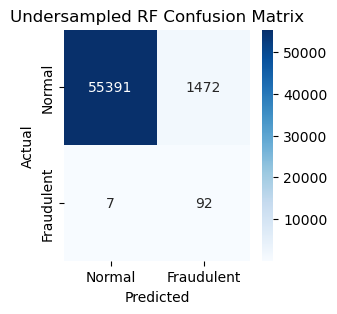

In [36]:
# prediction on validation set
y_val_pred_rfc_under = rfc_search_under.predict(X_val)
y_val_proba_rfc_under = rfc_search_under.predict_proba(X_val)[:, 1]

# model evaluation on validation set
model_val_eval('Undersampled RF', y_val, y_val_pred_rfc_under, y_val_proba_rfc_under)

Undersampling in the random forest achieved good recall (92%), but the precision dropped close to zero (6%). It appears that there is too much loss in information of the normal transactions.

#### Oversampling (ADASYN)

In [37]:
# oversampling initialisation
over_method = ADASYN(sampling_strategy=0.5, random_state=69) # ADASYN - fraudulent cases resampled to 50% of the majority class
#over_method = SMOTE(sampling_strategy=0.5, random_state=69) # SMOTE - fraudulent cases resampled to 50% of the majority class

# resampling training data
X_train_over, y_train_over = over_method.fit_resample(X_train, y_train)

Normal Transactions in oversampled training set (Class = 0):		170588	(66.64%)
Fraudulent Transactions in oversampled training set (Class = 1):	85379	(33.36%)


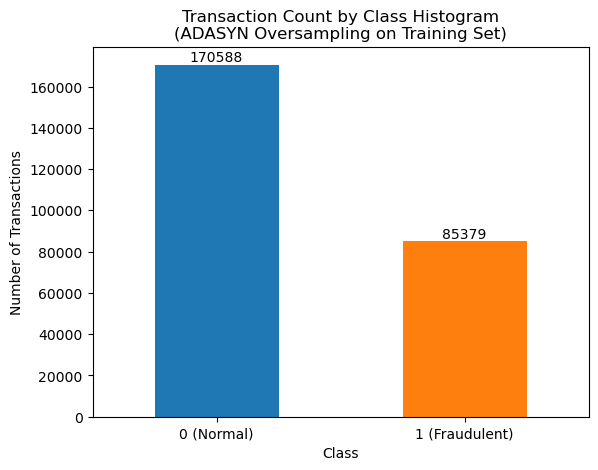

In [38]:
print(f"Normal Transactions in oversampled training set (Class = 0):\t\t{y_train_over.value_counts()[0]}\t({y_train_over.value_counts()[0] / len(y_train_over)*100:.2f}%)")
print(f"Fraudulent Transactions in oversampled training set (Class = 1):\t{y_train_over.value_counts()[1]}\t({y_train_over.value_counts()[1] / len(y_train_over)*100:.2f}%)")

class_vals_over = pd.Series(y_train_over).value_counts().sort_index()
ax = class_vals_over.plot(kind='bar', color=['tab:blue', 'tab:orange'])

plt.title('Transaction Count by Class Histogram\n(ADASYN Oversampling on Training Set)')
ax.set_xticklabels(['0 (Normal)', '1 (Fraudulent)'], rotation=0)
ax.set_ylabel('Number of Transactions')

for i, v in enumerate(class_vals_over):
    ax.text(i, v + max(v * 0.01, 5), str(v), ha='center');

/Users/cedrickeller/anaconda3/envs/cs5831/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


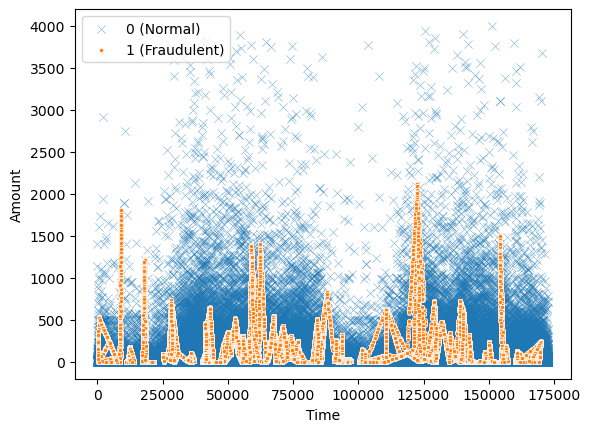

In [39]:
over_df = pd.DataFrame(X_train_over, columns=X_train_over.columns)
over_df['Class'] = y_train_over

sns.scatterplot(data=over_df[(over_df['Amount'] < 4000) & (over_df['Class'] == 0)], y='Amount', x='Time', alpha=0.5, marker='x', label='0 (Normal)')
sns.scatterplot(data=over_df[(over_df['Amount'] < 4000) & (over_df['Class'] == 1)], y='Amount', x='Time', alpha=1, marker='.', label='1 (Fraudulent)', color='tab:orange')
plt.legend();

In [40]:
# model initialization
rfc = RandomForestClassifier(random_state=69)

# hyperparameters to search
param_grid = {'n_estimators': [50, 100] # number of trees
              ,'max_depth': [5, 10, 15] # maximum depth of the tree
#              ,'max_features': ['auto', 'sqrt', 'log2'] # number of features at each split
}

# searching best hyperparameters
rfc_search_over = GridSearchCV(
    rfc,
    param_grid,
    cv=skf,
    scoring='roc_auc', # use 'roc_auc' or 'prediction_accuracy'
    n_jobs=-2 # n_iter=10 is default
)

# model training
rfc_search_over.fit(X_train_over, y_train_over)

print(f"Best Parameters:\t{rfc_search_over.best_params_}")

Best Parameters:	{'max_depth': 15, 'n_estimators': 100}


ROC AUC: 0.9837841688254083
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.84      0.82      0.83        99

    accuracy                           1.00     56962
   macro avg       0.92      0.91      0.91     56962
weighted avg       1.00      1.00      1.00     56962



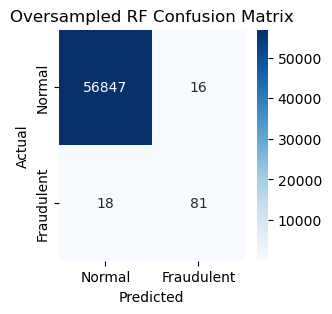

In [41]:
# prediction on validation set
y_val_pred_rfc_over = rfc_search_over.predict(X_val)
y_val_proba_rfc_over = rfc_search_over.predict_proba(X_val)[:, 1]

# model evaluation on validation set
model_val_eval('Oversampled RF', y_val, y_val_pred_rfc_over, y_val_proba_rfc_over)

Precision and recall are more balanced. However, there appears to be room for improvement as we have seen significantly higher precision or recall separately earlier.

#### Boosting

##### Assessing Boosting Method

In [42]:
# AdaBoost Model
adaboost = AdaBoostClassifier(n_estimators=50, random_state=69)
adaboost.fit(X_train, y_train)

# Gradient Boosting Model
gradientboosting = GradientBoostingClassifier(n_estimators=50, random_state=69)
gradientboosting.fit(X_train, y_train)

# XGBoost
xgbc = XGBClassifier(n_estimators=50, random_state=69, nthread=4)
xgbc.fit(X_train, y_train)

/Users/cedrickeller/anaconda3/envs/cs5831/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None, nthread=4,
              num_parallel_tree=None, ...)

In [43]:
# model evaluation
models = [adaboost, gradientboosting, xgbc]
model_names = ['AdaBoost', 'Gradient Boosting', 'XGBoost']

for model, name in zip(models, model_names):
    y_val_pred = model.predict(X_val)
    y_val_proba = model.predict_proba(X_val)[:, 1]
    cm = confusion_matrix(y_val, y_val_pred)

    print(f"{name} ROC AUC:", roc_auc_score(y_val, y_val_proba))
    print(f"{name} Classification Report:")
    print(classification_report(y_val, y_val_pred))
    #plot_confusion_matrix(cm, title=f"{name} Confusion Matrix")

AdaBoost ROC AUC: 0.9727963915396869
AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.79      0.71      0.74        99

    accuracy                           1.00     56962
   macro avg       0.89      0.85      0.87     56962
weighted avg       1.00      1.00      1.00     56962

Gradient Boosting ROC AUC: 0.5252255243286318
Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.81      0.35      0.49        99

    accuracy                           1.00     56962
   macro avg       0.91      0.68      0.75     56962
weighted avg       1.00      1.00      1.00     56962

XGBoost ROC AUC: 0.9751403204263589
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1  

XGBoost outperforms AdaBoost and Gradient Boosting in both precision and recall clearly. We will attempt more improvement through hyperparameter tuning.

##### Hyperparameter Tuned XGBoost Model

In [44]:
# scale_pos_weight (helps XGBoost handle imbalance)
neg, pos = y_train_over.value_counts()
scale_pos_weight = neg / pos

# model initialization
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    nthread=4,
    random_state=69
)

# hyperparameter grid
param_grid = {
    'n_estimators': [100, 500], # number of trees
    'max_depth': [3, 4, 5], # max depth of tree
    'min_child_weight': [1, 2], # about min samples per leaf
    'colsample_bytree': [0.8, 1], # max features per tree
    'learning_rate': [0.2, 0.3, 0.4]
}

# searching best hyperparameters
grid_search_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='roc_auc',  # use 'roc_auc' or 'average_precision'
    cv=skf,
    verbose=1,
    n_jobs=-1
)

# model training
grid_search_xgb.fit(X_train, y_train)

print(f"Best Parameters:\t{grid_search_xgb.best_params_}")

Fitting 5 folds for each of 72 candidates, totalling 360 fits


/Users/cedrickeller/anaconda3/envs/cs5831/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [16:27:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1742444238318/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/cedrickeller/anaconda3/envs/cs5831/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [16:27:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1742444238318/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/cedrickeller/anaconda3/envs/cs5831/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [16:27:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1742444238318/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/cedrickeller/anaconda3/envs/cs5831/lib/python3.10/site-packages/xgboost/core.py:158: UserWarn

Best Parameters:	{'colsample_bytree': 0.8, 'learning_rate': 0.4, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 500}


ROC AUC: 0.971833950713011
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.93      0.80      0.86        99

    accuracy                           1.00     56962
   macro avg       0.96      0.90      0.93     56962
weighted avg       1.00      1.00      1.00     56962



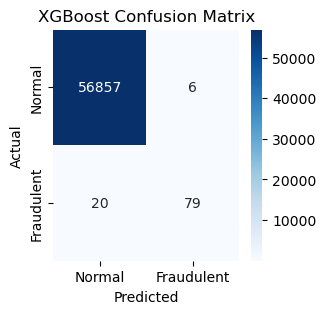

In [45]:
# prediction on validation set (best model)
y_val_pred_xgb = grid_search_xgb.predict(X_val)
y_val_proba_xgb = grid_search_xgb.predict_proba(X_val)[:, 1]

# model evaluation on validation set
model_val_eval('XGBoost', y_val, y_val_pred_xgb, y_val_proba_xgb)

XGBoost improved false labels, especially false positives. While the AUC is lower than in the oversampled RF, XGBoost will likely be more generalizable.

### Results

In [48]:
# function to get df of model performance
def get_model_performance_df(models):
    df = pd.DataFrame()

    for model_name, model in models.items():
        for split_set in ['Train', 'Validation', 'Test']:
            # prediction
            y_pred = model.predict(X_train if split_set=='Train' else X_val if split_set=='Validation' else X_test)
            y_proba = model.predict_proba(X_train if split_set=='Train' else X_val if split_set=='Validation' else X_test)[:, 1]

            # metrics
            auc = roc_auc_score(y_train if split_set=='Train' else y_val if split_set=='Validation' else y_test, y_proba)
            report = classification_report(y_train if split_set=='Train' else y_val if split_set=='Validation' else y_test, y_pred, output_dict=True)
            cm = confusion_matrix(y_train if split_set=='Train' else y_val if split_set=='Validation' else y_test, y_pred)
            tn, fp, fn, tp = cm.ravel()

            # append to dataframe
            df = pd.concat([df, pd.DataFrame({
                'Model': [model_name],
                'Split Set': [split_set],
                'ROC AUC': [auc],
                'Precision': [report['1']['precision']],
                'Recall': [report['1']['recall']],
                'F1 Score': [report['1']['f1-score']],
                'TP': [tp],
                'FP': [fp],
                'FN': [fn],
                'TN': [tn],
                'y_pred': [y_pred],
                'y_proba': [y_proba],
                'y_true': [y_train if split_set=='Train' else y_val if split_set == 'Validation' else y_test]
            })], ignore_index=True)

    return df

In [50]:
# all models
models = {
    'Decision Tree': dtc,
    'Imbalanced RF': rfc_search,
    'Undersampled RF': rfc_search_under,
    'Oversampled RF': rfc_search_over,
    'XGBoost': grid_search_xgb
}

# model performance df
model_performance_df = get_model_performance_df(models)
#model_performance_df.iloc[0:6,:]

#### ROC Curve

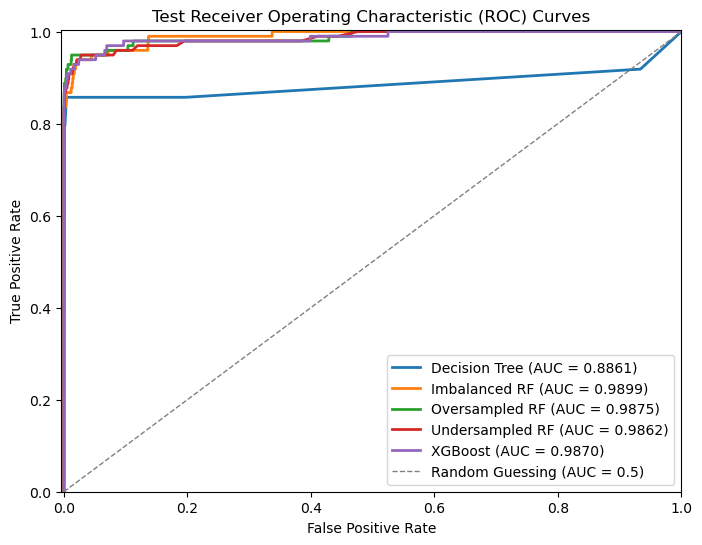

In [51]:
# df test set filter
test_df = model_performance_df[model_performance_df['Split Set'] == 'Test']

# ROC curve plotting (test set)
plt.figure(figsize=(8, 6))

for model_name, model_data in test_df.groupby('Model'):
    y_true = model_data['y_true'].iloc[0]
    y_proba = model_data['y_proba'].iloc[0]

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc_score = roc_auc_score(y_true, y_proba)
    
    # plot curve
    plt.plot(fpr, tpr, lw=2, label=f"{model_name} (AUC = {auc_score:.4f})")

# Plot the Random Guessing (0.5) line
plt.plot([0, 1], [0, 1], '--', color='gray', lw=1, label='Random Guessing (AUC = 0.5)')

# Customize the plot
plt.title('Test Receiver Operating Characteristic (ROC) Curves')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)

plt.xlim([-0.004, 1])
plt.ylim([0, 1.004])
plt.show()

The highest test AUC is achieved by the basic Random Forest with the imbalanced training set (0.9899), followed by the Oversampled Random Forest (0.9875), and the XGBoost model (0.9870). This observation is somewhat surprising but it shows the independence of the score from the threshold (set at 0.5 for all models).

#### Test Confusion Matrices Comparison

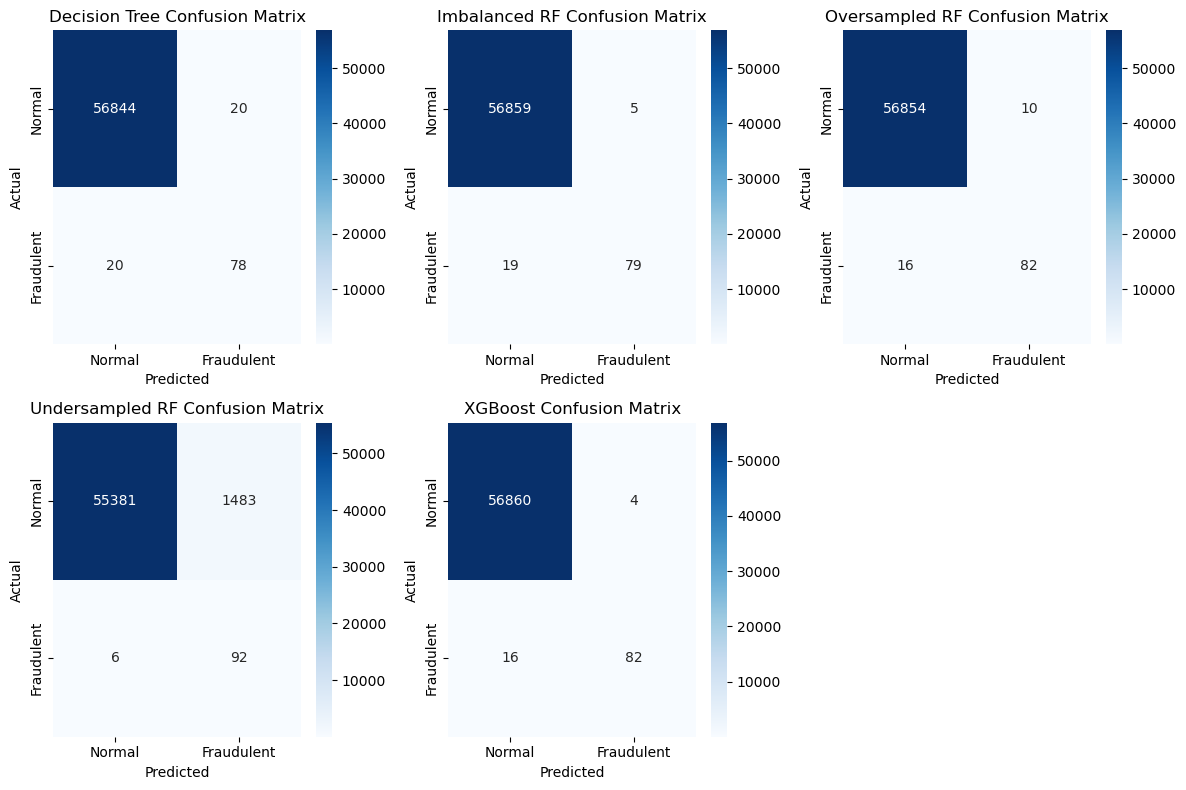

In [52]:
# confusion matrices plotting (test set)
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.ravel()

for idx, (model_name, model_data) in enumerate(test_df.groupby('Model')):
    y_true = model_data['y_true'].iloc[0]
    y_pred = model_data['y_pred'].iloc[0]
    cm = confusion_matrix(y_true, y_pred)

    # plotting function
    plot_confusion_matrix(cm, ax=axes[idx], title=f"{model_name} Confusion Matrix")

fig.delaxes(axes[-1]) # removes the unused subplot

plt.tight_layout();

When we compare the Confusion Matrices, there are more clear differences betweeen the models. Undersampling performs the worst with almost 1500 false positives (misclassifying normal transactions as fraudulent), but it does have the least false negatives (misclassifying fraudulent transactions as normal).
The imbalanced RF, oversampled RF, and XGBoost model are comparable, with the XGBoost model misclassifying the least transactions (total 20).

#### Model Results Overview

In [53]:
model_performance_df.iloc[:,:-3]

,Model,Split Set,ROC AUC,Precision,Recall,F1 Score,TP,FP,FN,TN
0,Decision Tree,Train,0.988363,1.000000,0.915254,0.955752,270,0,25,170588
1,Decision Tree,Validation,0.805430,0.800000,0.727273,0.761905,72,18,27,56845
2,Decision Tree,Test,0.886142,0.795918,0.795918,0.795918,78,20,20,56844
3,Imbalanced RF,Train,0.996296,1.000000,0.837288,0.911439,247,0,48,170588
4,Imbalanced RF,Validation,0.980414,0.911392,0.727273,0.808989,72,7,27,56856
5,Imbalanced RF,Test,0.989918,0.940476,0.806122,0.868132,79,5,19,56859
6,Undersampled RF,Train,0.999179,0.061229,1.000000,0.115392,295,4523,0,166065
7,Undersampled RF,Validation,0.982140,0.058824,0.929293,0.110643,92,1472,7,55391
8,Undersampled RF,Test,0.986175,0.058413,0.938776,0.109982,92,1483,6,55381
9,Oversampled RF,Train,0.999995,0.932907,0.989831,0.960526,292,21,3,170567


The XGBoost model appears to generalize the best. All metrics improved in the test set compared to the validation, notably the precision (95% vs. 93%), recall (84% vs 80%), and AUROC (98.70% vs. 97.18%). While the AUROC is not the highest, XGBoost has the least misclassifications. As a proven model, we can be more confident than with the other models that it is not overfitted and will perform well accurately classifying new data.

#### Feature Importance

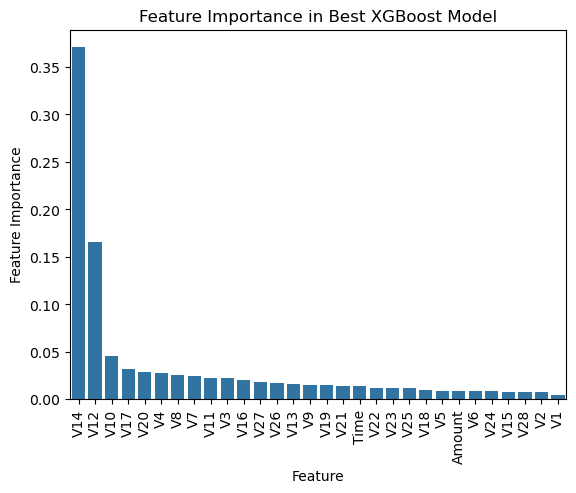

In [54]:
f_importance_df = pd.DataFrame({'Feature': X_val.columns, 'Feature Importance': grid_search_xgb.best_estimator_.feature_importances_})
f_importance_df = f_importance_df.sort_values(by='Feature Importance',ascending=False)

plt.title('Feature Importance in Best XGBoost Model')
sns.barplot(x='Feature', y='Feature Importance', data=f_importance_df);
plt.xticks(rotation=90);

The V14 principal component is by far the most important feature in the XGBoost model. It is used in 37% of the splits. V12 is also highly important accounting to 17% of use in splits.